## Telluric fitting

In [24]:
# Install JoviSpec
# git clone https://github.com/HajimeKawahara/jovispec.git
# python setup.py install

from decimal import Decimal
from jovispec import abcio
import pkg_resources


jupiter_data = pkg_resources.resource_filename("jovispec", "jupiter_data")

#red 
#rlambc, rspecc, rheadc=abcio.read_qfits("06033",jupiter_data,ext="q")
#rlambw, rspecw, rheadw=abcio.read_qfits("06047",jupiter_data,ext="q")
#rlambe, rspece, rheade=abcio.read_qfits("06049",jupiter_data,ext="q")

#blue
#rlamb1, rspec1, rhead=abcio.read_qfits("06000",jupiter_data,ext="q") #WASP33b
rlamb2, rspec2, rhead=abcio.read_qfits("06002",jupiter_data,ext="q") #WASP33b
rlamb3, rspec3, rhead=abcio.read_qfits("06004",jupiter_data,ext="q") #WASP33b
rlamb4, rspec4, rhead=abcio.read_qfits("06006",jupiter_data,ext="q") #WASP33b
rlamb5, rspec5, rhead=abcio.read_qfits("06008",jupiter_data,ext="q") #WASP33b
rlamb = rlamb2
rspec = rspec2 + rspec3 + rspec4 + rspec5

wavelength_start = 7100.0 #AA
wavelength_end = 7450.0 #AA

In [11]:
import matplotlib.pyplot as plt

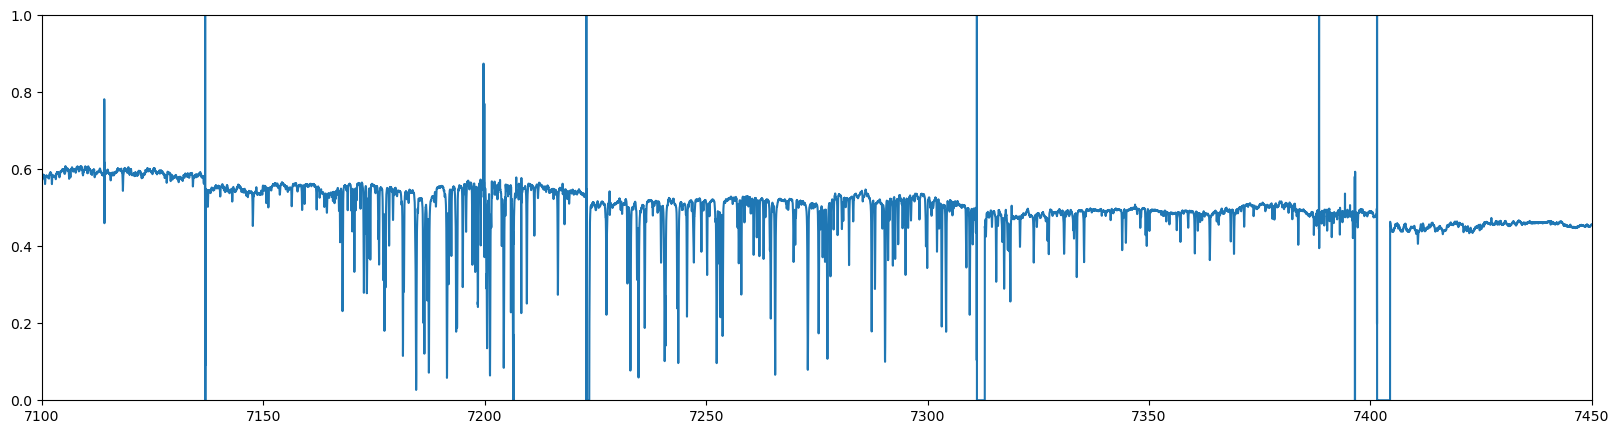

In [25]:
fig = plt.figure(figsize=(20,5))
plt.plot(rlamb,rspec)
plt.ylim(0.0,1.0)
plt.xlim(wavelength_start, wavelength_end)
plt.show()